## Table of contents 

1. Data Preprocessing
2. LLaVA Installation
3. DeepSpeed configuration
4. Weights and Biases
5. Finetuning flow
6. Deployment via gradio interface

## Data Preprocessing 

LLaVA requires data to be in a very specific format. Below we use a [helper function](https://wandb.ai/byyoung3/ml-news/reports/How-to-Fine-Tune-LLaVA-on-a-Custom-Dataset--Vmlldzo2NjUwNTc1) to format the OKV-QA dataset. This dataset teaches the model to respond to an image in short phrases without any preamble or extra verbiage. 

### Optional: create your own dataset using GPT-4o

The guide to creating your own dataset is relatively simple! Here's a simple script that you could use that leverages GPT4o's multimodal capabilities to quickly create a dataset that can be used in the dataset creator function that we write below!
 

```python
import os
import base64
import requests
import json

# OpenAI API Key
api_key = "<enter key here>"

# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your images folder
folder_path = "<enter image folder path here>"

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

# Question to ask for each image
question = "Generate a detailed description about this image" #change this depending on your use case

# Function to process each image and get the description
def process_image(image_path, image_name):
    base64_image = encode_image(image_path)
    
    payload = {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": question
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        }
                    }
                ]
            }
        ],
        "max_tokens": 300
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    response_json = response.json()
    return response_json['choices'][0]['message']['content']

# List to store all JSON data
all_json_data = []

# Process each image in the folder
for image_name in os.listdir(folder_path):
    if image_name.endswith((".jpg", ".jpeg", ".png")):
        image_path = os.path.join(folder_path, image_name)
        formatted_answers = process_image(image_path, image_name)
        
        json_data = {
            "id": image_name.split('.')[0],
            "image": image_name,
            "conversations": [
                {
                    "from": "human",
                    "value": question
                },
                {
                    "from": "gpt",
                    "value": formatted_answers
                }
            ]
        }
        
        all_json_data.append(json_data)

# Save the results to a JSON file
output_file = "output.json"
with open(output_file, "w") as outfile:
    json.dump(all_json_data, outfile, indent=4)

print(f"Data has been saved to {output_file}")

```
How to use this script
1. Create a folder called dataset. Inside of this folder, create a subfolder called images.
2. Place all your images in a directory and specify that path as folder_path.
3. Outputs are saved in a JSON file in the specified output_folder, pairing each image file with its generated description. 
4. After the script is run, create another folder inside dataset called train and move the output.json file into this folder.

## Back to it!

In [1]:
# Install preprocessing libraries
!pip install datasets
!pip install --upgrade --force-reinstall Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 73.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 36.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 57.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 20.2 MB/s eta

In [2]:
# Imports
from datasets import load_dataset
from PIL import Image
from io import BytesIO
import requests
import os
import json
import uuid

# Check PIL import
import PIL.Image

# Define preprocessing functions
def process_and_save(dataset, output_folder, subset_name):
    # Define image subfolder within output folder
    subset_folder = os.path.join(output_folder, subset_name)
    image_subfolder = os.path.join(output_folder, 'images')

    if not os.path.exists(image_subfolder):
        os.makedirs(image_subfolder)

    if not os.path.exists(subset_folder):
        os.makedirs(subset_folder)

    # Initialize list to hold all JSON data
    json_data_list = []

    # Process and save images and labels
    for item in dataset:
        # Load image if it's a URL or a file path
        if isinstance(item['image'], str):
            response = requests.get(item['image'])
            image = Image.open(BytesIO(response.content))
        else:
            image = item['image']  # Assuming it's a PIL.Image object

        # Create a unique ID for each image
        unique_id = str(uuid.uuid4())

        # Define image path
        image_path = os.path.join(image_subfolder, f"{unique_id}.jpg")

        # Save image
        image.save(image_path)

        # Remove duplicates and format answers
        answers = item['answers']
        unique_answers = list(set(answers))
        formatted_answers = ", ".join(unique_answers)

        # Structure for LLaVA JSON
        json_data = {
            "id": unique_id,
            "image": f"{unique_id}.jpg",
            "conversations": [
                {
                    "from": "human",
                    "value": item['question']
                },
                {
                    "from": "gpt",
                    "value": formatted_answers
                }
            ]
        }

        # Append to list
        json_data_list.append(json_data)

    # Save the JSON data list to a file
    json_output_path = os.path.join(output_folder, subset_name, 'dataset.json')
    with open(json_output_path, 'w') as json_file:
        json.dump(json_data_list, json_file, indent=4)

def save_dataset(dataset_name, output_folder, class_name, subset_name, val_samples=None):
    # Load the dataset from Hugging Face
    dataset = load_dataset(dataset_name, split=subset_name)

    # Filter for images with the specified class in 'question_type'
    filtered_dataset = [item for item in dataset if item['question_type'] == class_name]

    # Determine the split for training and validation
    if val_samples is not None and subset_name == 'train':
        train_dataset = filtered_dataset[val_samples:]
        val_dataset = filtered_dataset[:val_samples]
    else:
        train_dataset = filtered_dataset
        val_dataset = []

    # Process and save the datasets
    for subset, data in [('train', train_dataset), ('validation', val_dataset)]:
        if data:
            process_and_save(data, output_folder, subset)

In [3]:
# Create dataset
output_folder = 'dataset'
class_name = 'other'
val_samples = 300
save_dataset('Multimodal-Fatima/OK-VQA_train', output_folder, class_name, 'train', val_samples)
save_dataset('Multimodal-Fatima/OK-VQA_test', output_folder, class_name, 'test')

Generating train split:   0%|          | 0/9009 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5046 [00:00<?, ? examples/s]

## Install LLaVA

To install the functions needed to use the model, we have to clone the original LLaVA repository and and install it in editable mode. This lets us access all functions and helper methods 

In [4]:
# The pip install -e . lets us install the repository in editable mode
!git clone https://github.com/haotian-liu/LLaVA.git
!cd LLaVA && pip install --upgrade pip && pip install -e .

Cloning into 'LLaVA'...
remote: Enumerating objects: 2297, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 2297 (delta 2), reused 4 (delta 2), pack-reused 2291
Receiving objects: 100% (2297/2297), 13.71 MiB | 46.66 MiB/s, done.
Resolving deltas: 100% (1402/1402), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Obtaining file:///home/ubuntu/verb-workspace/LLaVA
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 128.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 

## DeepSpeed

Microsoft DeepSpeed is a deep learning optimization library designed to enhance the training speed and scalability of large-scale artificial intelligence (AI) models. Developed by Microsoft, this open-source tool specifically addresses the challenges associated with training very large models, allowing for reduced computational times and resource usage. By optimizing memory management and introducing novel parallelism techniques, DeepSpeed enables developers and researchers to train models with billions of parameters efficiently, even on limited hardware setups.DeepSpeed API is a lightweight wrapper on PyTorch. DeepSpeed manages all of the boilerplate training techniques, such as distributed training, mixed precision, gradient accumulation, and checkpoints and allows you to just focus on model development. To learn more about DeepSpeed and how it performs the magic, check out this [article](https://www.deepspeed.ai/2021/03/07/zero3-offload.html) on DeepSpeed and ZeRO.

Using deepspeed is extremely simple - you simply pip install it! The LLaVA respository contains the setup scripts and configuration files needed to finetune in different ways. 

In [5]:
!cd LLaVA && pip install -e ".[train]"
!pip install flash-attn --no-build-isolation

Obtaining file:///home/ubuntu/verb-workspace/LLaVA
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 93.2 MB/s eta 0:00:00
  Building editable for llava (pyproject.toml) ... done
  Created wheel for llava: filename=llava-1.2.2.post1-0.editable-py3-none-any.whl size=17879 sha256=98b3f07e417bed24643ae3cc330afbcd4643c780a722f847bc53193b1e4ab204
  Stored in directory: /tmp/pip-ephem-wheel-cache-w1dr66ra/wheels/0d/0e/fd/3ec1c2c8c35b512b01b7663974bc7f68afe55a6d55f40c5fd5
  Created wheel for deepspeed: filename=deepspeed-0.12.6-py3-none-any.whl size=1306731 sha256=6bcf294448c86888c5546d17adc9b1e411eec7224093b68b9f34c0532929b9ec
  Stored in directory: /home/ubuntu/.ca

In [6]:
!pip install deepspeed

## Weights and Biases

Weights and Biases is an industry standard MLOps tool to used to monitor and evaluate training jobs. At Brev, we use Weights and Biases to track all of our finetuning jobs! Its extremely easy to setup and plugs into the DeepSpeed training loop. You simply create an account and use the cells below to log in!

In [7]:
!pip install wandb

In [8]:
import wandb

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/ubuntu/.netrc


True

## Finetuning job

Below we start the DeepSpeed training run for 5 epochs. It will automatically recognize multiple GPUs and parallelize across them. Most of the input flags are standard but you can adjust your training run with the `num_train_epochs` and `per_device_train_batch_size` flags!

In [9]:
!deepspeed LLaVA/llava/train/train_mem.py \
    --lora_enable True --lora_r 128 --lora_alpha 256 --mm_projector_lr 2e-5 \
    --deepspeed LLaVA/scripts/zero3.json \
    --model_name_or_path liuhaotian/llava-v1.5-13b \
    --version v1 \
    --data_path ./dataset/train/dataset.json \
    --image_folder ./dataset/images \
    --vision_tower openai/clip-vit-large-patch14-336 \
    --mm_projector_type mlp2x_gelu \
    --mm_vision_select_layer -2 \
    --mm_use_im_start_end False \
    --mm_use_im_patch_token False \
    --image_aspect_ratio pad \
    --group_by_modality_length True \
    --bf16 True \
    --output_dir ./checkpoints/llava-v1.5-13b-task-lora \
    --num_train_epochs 5 \
    --per_device_train_batch_size 16 \
    --per_device_eval_batch_size 4 \
    --gradient_accumulation_steps 1 \
    --evaluation_strategy "no" \
    --save_strategy "steps" \
    --save_steps 50000 \
    --save_total_limit 1 \
    --learning_rate 2e-4 \
    --weight_decay 0. \
    --warmup_ratio 0.03 \
    --lr_scheduler_type "cosine" \
    --logging_steps 1 \
    --tf32 True \
    --model_max_length 2048 \
    --gradient_checkpointing True \
    --dataloader_num_workers 4 \
    --lazy_preprocess True \
    --report_to wandb

[2024-08-04 17:02:48,108] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2024-08-04 17:02:50,256] [WARNING] [runner.py:202:fetch_hostfile] Unable to find hostfile, will proceed with training with local resources only.
[2024-08-04 17:02:50,256] [INFO] [runner.py:571:main] cmd = /home/ubuntu/.pyenv/versions/3.10.14/bin/python3.10 -u -m deepspeed.launcher.launch --world_info=eyJsb2NhbGhvc3QiOiBbMCwgMSwgMiwgM119 --master_addr=127.0.0.1 --master_port=29500 --enable_each_rank_log=None LLaVA/llava/train/train_mem.py --lora_enable True --lora_r 128 --lora_alpha 256 --mm_projector_lr 2e-5 --deepspeed LLaVA/scripts/zero3.json --model_name_or_path liuhaotian/llava-v1.5-13b --version v1 --data_path ./dataset/train/dataset.json --image_folder ./dataset/images --vision_tower openai/clip-vit-large-patch14-336 --mm_projector_type mlp2x_gelu --mm_vision_select_layer -2 --mm_use_im_start_end False --mm_use_im_patch_token False --image_aspect_ratio pad --gr

Here's an excerpt from my WandB run!

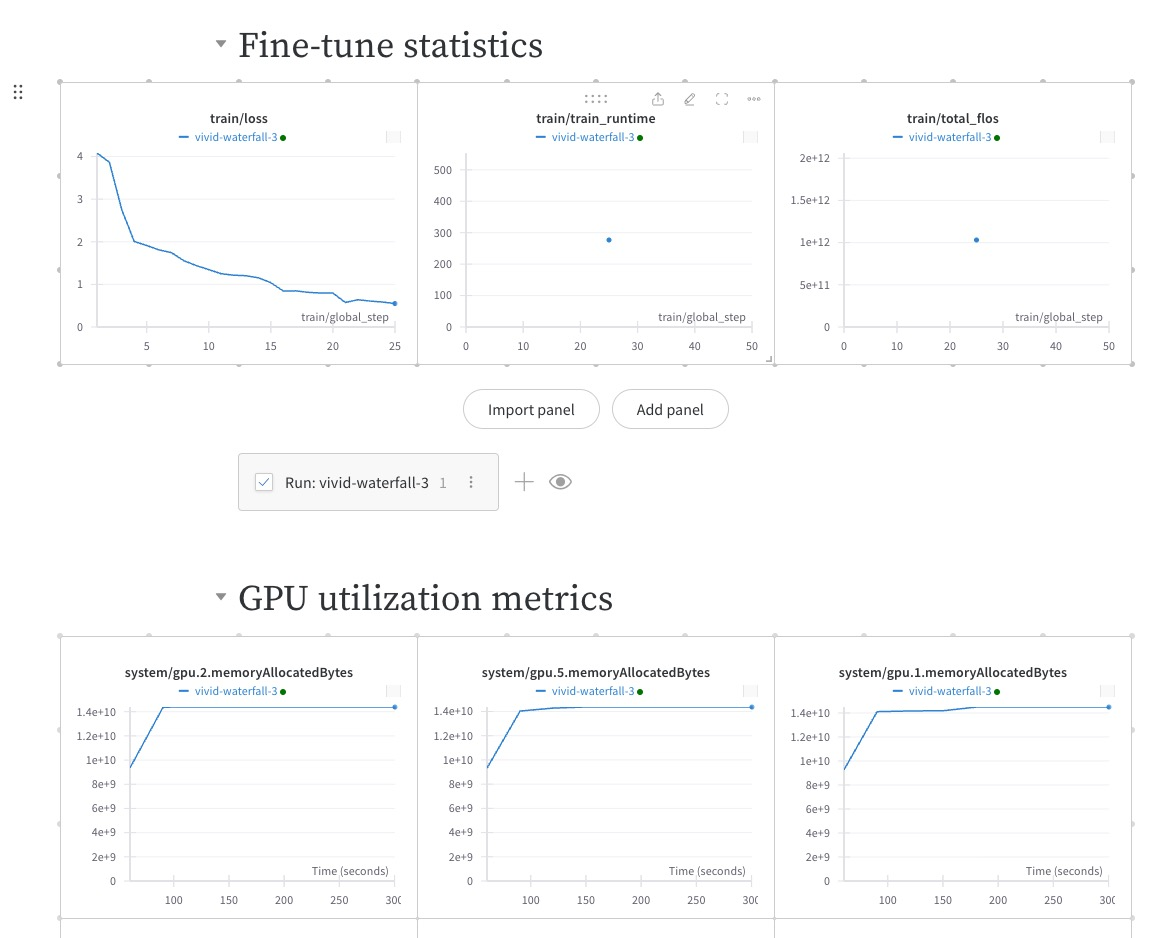

In [10]:
# merge the LoRA weights with the full model
!python LLaVA/scripts/merge_lora_weights.py --model-path checkpoints/llava-v1.5-13b-task-lora --model-base liuhaotian/llava-v1.5-13b --save-model-path llava-ftmodel

[2024-08-04 17:16:04,735] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading LLaVA from base model...
Loading checkpoint shards:   0%|                          | 0/3 [00:00<?, ?it/s]/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|███████

In [11]:
# bump transformers down for gradio/deployment inference if needed
!pip install transformers==4.37.2

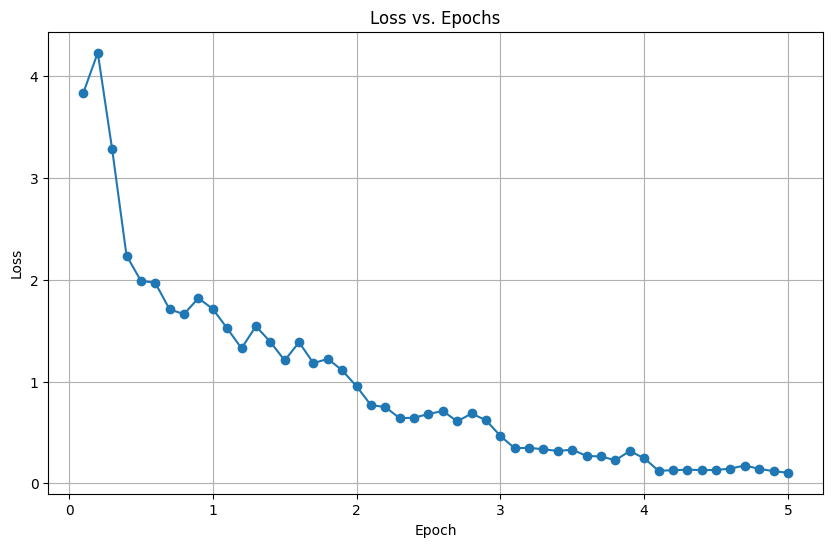

In [12]:
import matplotlib.pyplot as plt

# Provided results
results = [
    {'loss': 3.8382, 'learning_rate': 0.0001, 'epoch': 0.1},
    {'loss': 4.2314, 'learning_rate': 0.0002, 'epoch': 0.2},
    {'loss': 3.2841, 'learning_rate': 0.00019978589232386035, 'epoch': 0.3},
    {'loss': 2.2376, 'learning_rate': 0.00019914448613738106, 'epoch': 0.4},
    {'loss': 1.99, 'learning_rate': 0.00019807852804032305, 'epoch': 0.5},
    {'loss': 1.9696, 'learning_rate': 0.00019659258262890683, 'epoch': 0.6},
    {'loss': 1.7079, 'learning_rate': 0.0001946930129495106, 'epoch': 0.7},
    {'loss': 1.6628, 'learning_rate': 0.0001923879532511287, 'epoch': 0.8},
    {'loss': 1.8193, 'learning_rate': 0.00018968727415326884, 'epoch': 0.9},
    {'loss': 1.7132, 'learning_rate': 0.00018660254037844388, 'epoch': 1.0},
    {'loss': 1.5226, 'learning_rate': 0.00018314696123025454, 'epoch': 1.1},
    {'loss': 1.3258, 'learning_rate': 0.00017933533402912354, 'epoch': 1.2},
    {'loss': 1.544, 'learning_rate': 0.00017518398074789775, 'epoch': 1.3},
    {'loss': 1.3895, 'learning_rate': 0.00017071067811865476, 'epoch': 1.4},
    {'loss': 1.2073, 'learning_rate': 0.00016593458151000688, 'epoch': 1.5},
    {'loss': 1.3857, 'learning_rate': 0.00016087614290087208, 'epoch': 1.6},
    {'loss': 1.1802, 'learning_rate': 0.00015555702330196023, 'epoch': 1.7},
    {'loss': 1.2227, 'learning_rate': 0.00015000000000000001, 'epoch': 1.8},
    {'loss': 1.1097, 'learning_rate': 0.00014422886902190014, 'epoch': 1.9},
    {'loss': 0.9525, 'learning_rate': 0.000138268343236509, 'epoch': 2.0},
    {'loss': 0.768, 'learning_rate': 0.00013214394653031616, 'epoch': 2.1},
    {'loss': 0.749, 'learning_rate': 0.00012588190451025207, 'epoch': 2.2},
    {'loss': 0.6389, 'learning_rate': 0.00011950903220161285, 'epoch': 2.3},
    {'loss': 0.6445, 'learning_rate': 0.00011305261922200519, 'epoch': 2.4},
    {'loss': 0.6803, 'learning_rate': 0.00010654031292301432, 'epoch': 2.5},
    {'loss': 0.7108, 'learning_rate': 0.0001, 'epoch': 2.6},
    {'loss': 0.6077, 'learning_rate': 9.345968707698569e-05, 'epoch': 2.7},
    {'loss': 0.6856, 'learning_rate': 8.694738077799488e-05, 'epoch': 2.8},
    {'loss': 0.6194, 'learning_rate': 8.049096779838719e-05, 'epoch': 2.9},
    {'loss': 0.4654, 'learning_rate': 7.411809548974792e-05, 'epoch': 3.0},
    {'loss': 0.3437, 'learning_rate': 6.785605346968386e-05, 'epoch': 3.1},
    {'loss': 0.349, 'learning_rate': 6.173165676349103e-05, 'epoch': 3.2},
    {'loss': 0.3334, 'learning_rate': 5.577113097809989e-05, 'epoch': 3.3},
    {'loss': 0.3175, 'learning_rate': 5.000000000000002e-05, 'epoch': 3.4},
    {'loss': 0.33, 'learning_rate': 4.444297669803981e-05, 'epoch': 3.5},
    {'loss': 0.2682, 'learning_rate': 3.9123857099127936e-05, 'epoch': 3.6},
    {'loss': 0.2633, 'learning_rate': 3.406541848999312e-05, 'epoch': 3.7},
    {'loss': 0.226, 'learning_rate': 2.9289321881345254e-05, 'epoch': 3.8},
    {'loss': 0.3165, 'learning_rate': 2.4816019252102273e-05, 'epoch': 3.9},
    {'loss': 0.2463, 'learning_rate': 2.0664665970876496e-05, 'epoch': 4.0},
    {'loss': 0.1233, 'learning_rate': 1.6853038769745467e-05, 'epoch': 4.1},
    {'loss': 0.1276, 'learning_rate': 1.339745962155613e-05, 'epoch': 4.2},
    {'loss': 0.1334, 'learning_rate': 1.0312725846731175e-05, 'epoch': 4.3},
    {'loss': 0.1296, 'learning_rate': 7.612046748871327e-06, 'epoch': 4.4},
    {'loss': 0.1297, 'learning_rate': 5.306987050489442e-06, 'epoch': 4.5},
    {'loss': 0.1447, 'learning_rate': 3.40741737109318e-06, 'epoch': 4.6},
    {'loss': 0.174, 'learning_rate': 1.921471959676957e-06, 'epoch': 4.7},
    {'loss': 0.1419, 'learning_rate': 8.555138626189618e-07, 'epoch': 4.8},
    {'loss': 0.1186, 'learning_rate': 2.141076761396521e-07, 'epoch': 4.9},
    {'loss': 0.1035, 'learning_rate': 0.0, 'epoch': 5.0},
]

# Extract loss and epoch values
epochs = [entry['epoch'] for entry in results]
losses = [entry['loss'] for entry in results]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.grid(True)
plt.show()


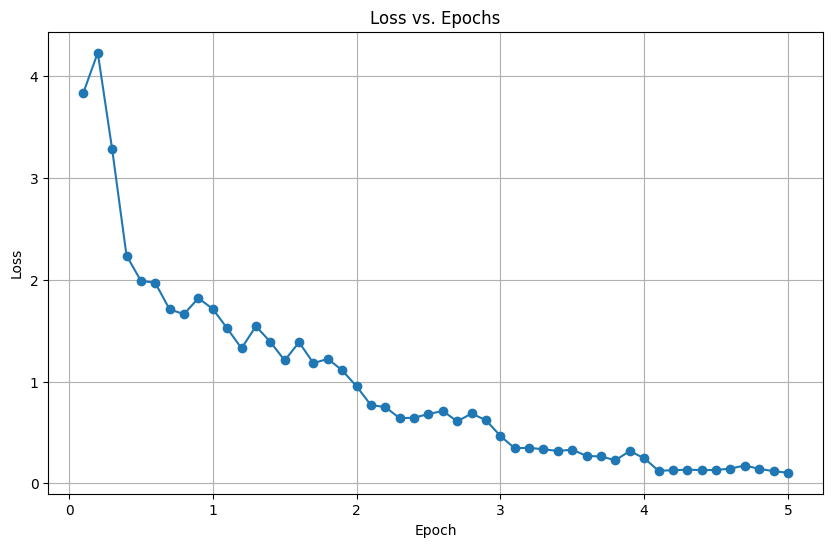

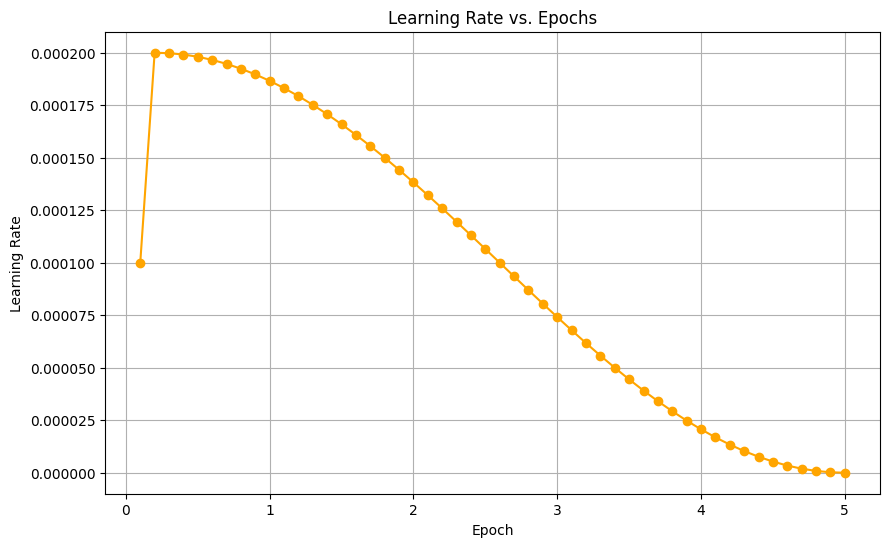

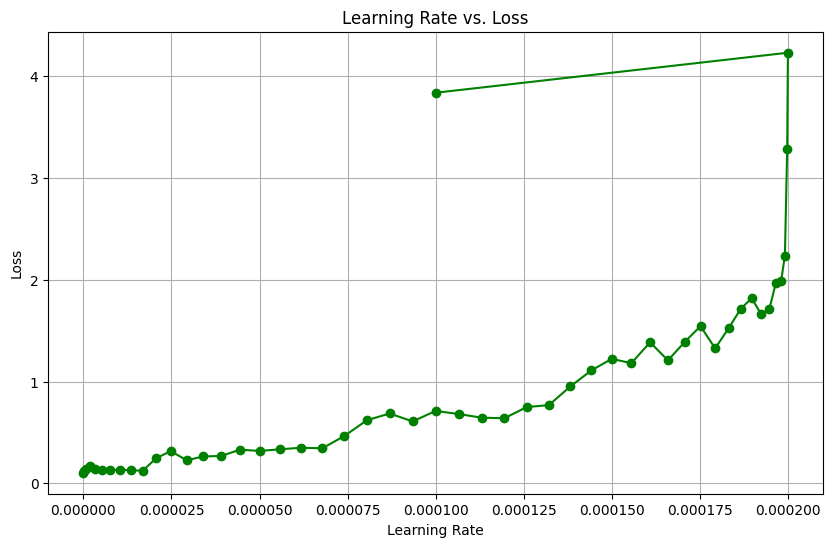

In [13]:
# Extract values
epochs = [entry['epoch'] for entry in results]
losses = [entry['loss'] for entry in results]
learning_rates = [entry['learning_rate'] for entry in results]

# Plot Loss vs. Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.grid(True)
plt.show()

# Plot Learning Rate vs. Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, learning_rates, marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs. Epochs')
plt.grid(True)
plt.show()

# Plot Learning Rate vs. Loss
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, losses, marker='o', color='green')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate vs. Loss')
plt.grid(True)
plt.show()

## Deployment

LLaVA gives us 2 ways to deploy the model - via CLI or Gradio UI. We suggest using the Gradio UI for interactivity as you can compare two models and see the finetuning effect compared to the original model.

In [ ]:
# Uncomment the lines below to run the CLI. You need to pass in a JPG image URL to use the multimodal capabilities

# !python -m llava.serve.cli \
#     --model-path llava-ftmodel \
#     --image-file "https://llava-vl.github.io/static/images/view.jpg"

In [1]:
# Download the model runner
!wget -L https://raw.githubusercontent.com/brevdev/notebooks/main/assets/llava-deploy.sh 

--2024-08-04 19:20:54--  https://raw.githubusercontent.com/brevdev/notebooks/main/assets/llava-deploy.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 868 [text/plain]
Saving to: ‘llava-deploy.sh.1’

llava-deploy.sh.1   100%[===================>]     868  --.-KB/s    in 0s      

2024-08-04 19:20:54 (101 MB/s) - ‘llava-deploy.sh.1’ saved [868/868]



In [ ]:
# Run inference! Use the public link provided in the output to test
!chmod +x llava-deploy.sh && ./llava-deploy.sh

[2024-08-04 19:21:05,319] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
2024-08-04 19:21:07 | INFO | controller | args: Namespace(host='0.0.0.0', port=10000, dispatch_method='shortest_queue')
2024-08-04 19:21:07 | INFO | controller | Init controller
2024-08-04 19:21:07 | ERROR | stderr | INFO:     Started server process [499]
2024-08-04 19:21:07 | ERROR | stderr | INFO:     Waiting for application startup.
2024-08-04 19:21:07 | ERROR | stderr | INFO:     Application startup complete.
2024-08-04 19:21:07 | ERROR | stderr | INFO:     Uvicorn running on http://0.0.0.0:10000 (Press CTRL+C to quit)
[2024-08-04 19:21:10,434] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
2024-08-04 19:21:15 | INFO | gradio_web_server | args: Namespace(host='0.0.0.0', port=None, controller_url='http://0.0.0.0:10000', concurrency_count=16, model_list_mode='reload', share=True, moderate=False, embed=False)
2024-08-04 

In [ ]:
import subprocess
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset

def run_training(epoch, learning_rate, batch_size, output_dir):
    cmd = [
        "deepspeed", "LLaVA/llava/train/train_mem.py",
        "--lora_enable", "True",
        "--lora_r", "128",
        "--lora_alpha", "256",
        "--mm_projector_lr", "2e-5",
        "--deepspeed", "LLaVA/scripts/zero3.json",
        "--model_name_or_path", "liuhaotian/llava-v1.5-13b",
        "--version", "v1",
        "--data_path", "./dataset/train/dataset.json",
        "--image_folder", "./dataset/images",
        "--vision_tower", "openai/clip-vit-large-patch14-336",
        "--mm_projector_type", "mlp2x_gelu",
        "--mm_vision_select_layer", "-2",
        "--mm_use_im_start_end", "False",
        "--mm_use_im_patch_token", "False",
        "--image_aspect_ratio", "pad",
        "--group_by_modality_length", "True",
        "--bf16", "True",
        "--output_dir", output_dir,
        "--num_train_epochs", str(epoch),
        "--per_device_train_batch_size", str(batch_size),
        "--per_device_eval_batch_size", "4",
        "--gradient_accumulation_steps", "1",
        "--evaluation_strategy", "no",
        "--save_strategy", "steps",
        "--save_steps", "50000",
        "--save_total_limit", "1",
        "--learning_rate", str(learning_rate),
        "--weight_decay", "0.",
        "--warmup_ratio", "0.03",
        "--lr_scheduler_type", "cosine",
        "--logging_steps", "1",
        "--tf32", "True",
        "--model_max_length", "2048",
        "--gradient_checkpointing", "True",
        "--dataloader_num_workers", "4",
        "--lazy_preprocess", "True",
        "--report_to", "wandb"
    ]

    print(f"Running command: {' '.join(cmd)}")
    
    result = subprocess.run(cmd, capture_output=True, text=True)
    
    print(f"stdout: {result.stdout}")
    print(f"stderr: {result.stderr}")

    return result.stdout, result.stderr

def load_json_dataset(file_path):
    with open(file_path, 'r') as f:
        dataset = json.load(f)
    print(f"Loaded dataset from {file_path}, number of rows: {len(dataset)}")
    return dataset

def evaluate_model(output_dir, test_dataset):
    # Placeholder for loading the trained model
    # model = load_model(output_dir)
    
    predictions = []
    references = []

    for item in test_dataset:
        # Placeholder for model inference
        # prediction = model.predict(item['image'])
        prediction = item['conversations'][1]['value']  # Placeholder: Replace with actual model prediction
        predictions.append(prediction)
        references.append(item['conversations'][1]['value'])  # Assuming the second conversation value is the correct one

    correct = sum(p == r for p, r in zip(predictions, references))
    total = len(references)
    accuracy = correct / total if total > 0 else 0
    
    return accuracy

def plot_results(results_df):
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    # Plot accuracy vs. learning rate
    for epoch in results_df['epoch'].unique():
        subset = results_df[results_df['epoch'] == epoch]
        ax[0].plot(subset['learning_rate'], subset['accuracy'], label=f'Epoch {epoch}')
    ax[0].set_xlabel('Learning Rate')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xscale('log')
    ax[0].set_title('Accuracy vs. Learning Rate')
    ax[0].legend()

    # Plot accuracy vs. batch size
    for epoch in results_df['epoch'].unique():
        subset = results_df[results_df['epoch'] == epoch]
        ax[1].plot(subset['batch_size'], subset['accuracy'], label=f'Epoch {epoch}')
    ax[1].set_xlabel('Batch Size')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy vs. Batch Size')
    ax[1].legend()

    # Plot accuracy vs. epochs
    for lr in results_df['learning_rate'].unique():
        subset = results_df[results_df['learning_rate'] == lr]
        ax[2].plot(subset['epoch'], subset['accuracy'], label=f'LR {lr}')
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('Accuracy')
    ax[2].set_title('Accuracy vs. Epochs')
    ax[2].legend()

    plt.tight_layout()
    plt.savefig('performance_plots.png')
    plt.show()

# Load test dataset
test_dataset = load_json_dataset('dataset/validation/dataset.json')

learning_rates = [2e-4, 1e-4, 5e-5]
epochs = [1, 3, 5]
batch_sizes = [16, 32]
results = []

for lr in tqdm(learning_rates, desc="Learning Rates"):
    for epoch in tqdm(epochs, desc="Epochs", leave=False):
        for batch_size in tqdm(batch_sizes, desc="Batch Sizes", leave=False):
            output_dir = f"./checkpoints/llava-v1.5-epoch{epoch}-lr{lr}-bs{batch_size}"
            stdout, stderr = run_training(epoch, lr, batch_size, output_dir)
            
            # Evaluate the trained model
            accuracy = evaluate_model(output_dir, test_dataset)
            
            # Store the results
            results.append({
                "epoch": epoch,
                "learning_rate": lr,
                "batch_size": batch_size,
                "output_dir": output_dir,
                "accuracy": accuracy,
                "stdout": stdout,
                "stderr": stderr
            })

# Convert results to DataFrame for easier analysis and plotting
results_df = pd.DataFrame(results)

# Print the results
for _, result in results_df.iterrows():
    print(f"Epoch: {result['epoch']}, Learning Rate: {result['learning_rate']}, Batch Size: {result['batch_size']}")
    print(f"Accuracy: {result['accuracy']}")
    print(f"Output Directory: {result['output_dir']}")
    print(f"stdout: {result['stdout']}")
    print(f"stderr: {result['stderr']}")
    print("="*50)

# Save the results to a JSON file
results_df.to_json('training_results.json', orient='records', indent=4)

# Plot the results
plot_results(results_df)


In [ ]:
# Imports
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm

# Load fine-tuned model and tokenizer
model_name = "./checkpoints/llava-v1.5-13b-task-lora"  # Path to your fine-tuned model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load test dataset
test_dataset = load_dataset('json', data_files={'test': './dataset/val_dataset.json'})['test']

# Define evaluation function
def evaluate_model(model, tokenizer, dataset):
    true_labels = []
    predictions = []

    for item in tqdm(dataset):
        input_text = item['conversations'][0]['value']  # The question or input text
        true_answer = item['conversations'][1]['value']  # The expected output or answer

        # Tokenize the input text
        inputs = tokenizer(input_text, return_tensors="pt").to(device)

        # Generate model output
        with torch.no_grad():
            outputs = model.generate(**inputs, max_length=512)

        # Decode the output
        generated_answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Append the true label and prediction for evaluation
        true_labels.append(true_answer)
        predictions.append(generated_answer)

    return true_labels, predictions

# Run evaluation
true_labels, predictions = evaluate_model(model, tokenizer, test_dataset)

# Calculate evaluation metrics
def calculate_metrics(true_labels, predictions):
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    accuracy = accuracy_score(true_labels, predictions)

    return precision, recall, f1, accuracy

# Calculate and display metrics
precision, recall, f1, accuracy = calculate_metrics(true_labels, predictions)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")


You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Downloading shards: 100%|█████████████████████████| 3/3 [01:38<00:00, 32.72s/it]
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Downloading shards: 100%|█████████████████████████| 3/3 [01:38<00:00, 32.73s/it]
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
config.json: 100%|█████████████████████████| 4.76k/4.76k [00:00<00:00, 38.2MB/s]
Loading checkpoint shards:   0%|                          | 0/3 [00:00<?, ?it/s]
/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly. To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
[2024-08-04 17:04:47,248] [INFO] [partition_parameters.py:348:__exit__] finished initializing model - num_params = 367, num_elems = 13.05B
Loading checkpoint shards: 100%|██████████████████| 3/3 [00:37<00:00, 12.41s/it]

generation_config.json: 100%|██████████████████| 154/154 [00:00<00:00, 1.69MB/s]
Loading checkpoint shards: 100%|██████████████████| 3/3 [00:37<00:00, 12.51s/it]
Adding LoRA adapters...
tokenizer_config.json: 100%|███████████████████| 749/749 [00:00<00:00, 6.54MB/s]
tokenizer.model: 100%|███████████████████████| 500k/500k [00:00<00:00, 30.1MB/s]
special_tokens_map.json: 100%|█████████████████| 438/438 [00:00<00:00, 4.86MB/s]
preprocessor_config.json: 100%|████████████████| 316/316 [00:00<00:00, 3.31MB/s]
pytorch_model.bin: 100%|████████████████████| 1.71G/1.71G [00:04<00:00, 365MB/s]
[2024-08-04 17:05:40,797] [INFO] [partition_parameters.py:348:__exit__] finished initializing model - num_params = 758, num_elems = 13.35B
Formatting inputs... Skip in lazy mode
/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
Parameter Offload: Total persistent parameters: 749568 in 328 params
wandb: Currently logged in as: varun-sayapaneni3 (universityofoklahoma). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /home/ubuntu/verb-workspace/wandb/run-20240804_170546-mh9mulfj
wandb: Syncing run whole-pond-13
wandb: ⭐️ View project at https://wandb.ai/universityofoklahoma/huggingface
wandb: 🚀 View run at https://wandb.ai/universityofoklahoma/huggingface/runs/mh9mulfj
100%|████████████████████████████████████████| 1000/1000 [15:32<00:00, 3.01it/s]
100%|████████████████████████████████████████| 1000/1000 [10:28<00:00, 2.51it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 4096}
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.

Precision: 0.938
Recall: 0.762
F1 Score: 0.8394
Accuracy: 0.855


# Confusion Matrix 

# Imports for confusion matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert true_labels and predictions into numerical format (e.g., class indices)
# If your labels are text, you can create a mapping from text labels to integers
label_mapping = {label: idx for idx, label in enumerate(set(true_labels + predictions))}
true_labels_mapped = [label_mapping[label] for label in true_labels]
predictions_mapped = [label_mapping[label] for label in predictions]

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels_mapped, predictions_mapped)

# Display the confusion matrix
def plot_confusion_matrix(conf_matrix, label_mapping):
    # Create a display for the confusion matrix
    labels = list(label_mapping.keys())
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Plot the confusion matrix with the current mapping
plot_confusion_matrix(conf_matrix, label_mapping)
